### Time Series as Features

In [1]:
import pandas as pd
import numpy as np

In [14]:
reserve = pd.read_csv("./archive/reserve.csv", parse_dates={"Date": ["Year", "Month", "Day"]}, index_col="Date")
reserve.head()

y = reserve["Unemployment Rate"].dropna().to_period("M")
y.info()
df = pd.DataFrame({
    "y": y,
    "y_lag1": y.shift(1),
    "y_lag2": y.shift(2)
    })
df.head()

<class 'pandas.core.series.Series'>
PeriodIndex: 752 entries, 1954-07 to 2017-02
Freq: M
Series name: Unemployment Rate
Non-Null Count  Dtype  
--------------  -----  
752 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB


,y,y_lag1,y_lag2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


#### Example - Flu Trends

In [16]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

In [17]:
# Plotting
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

In [19]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


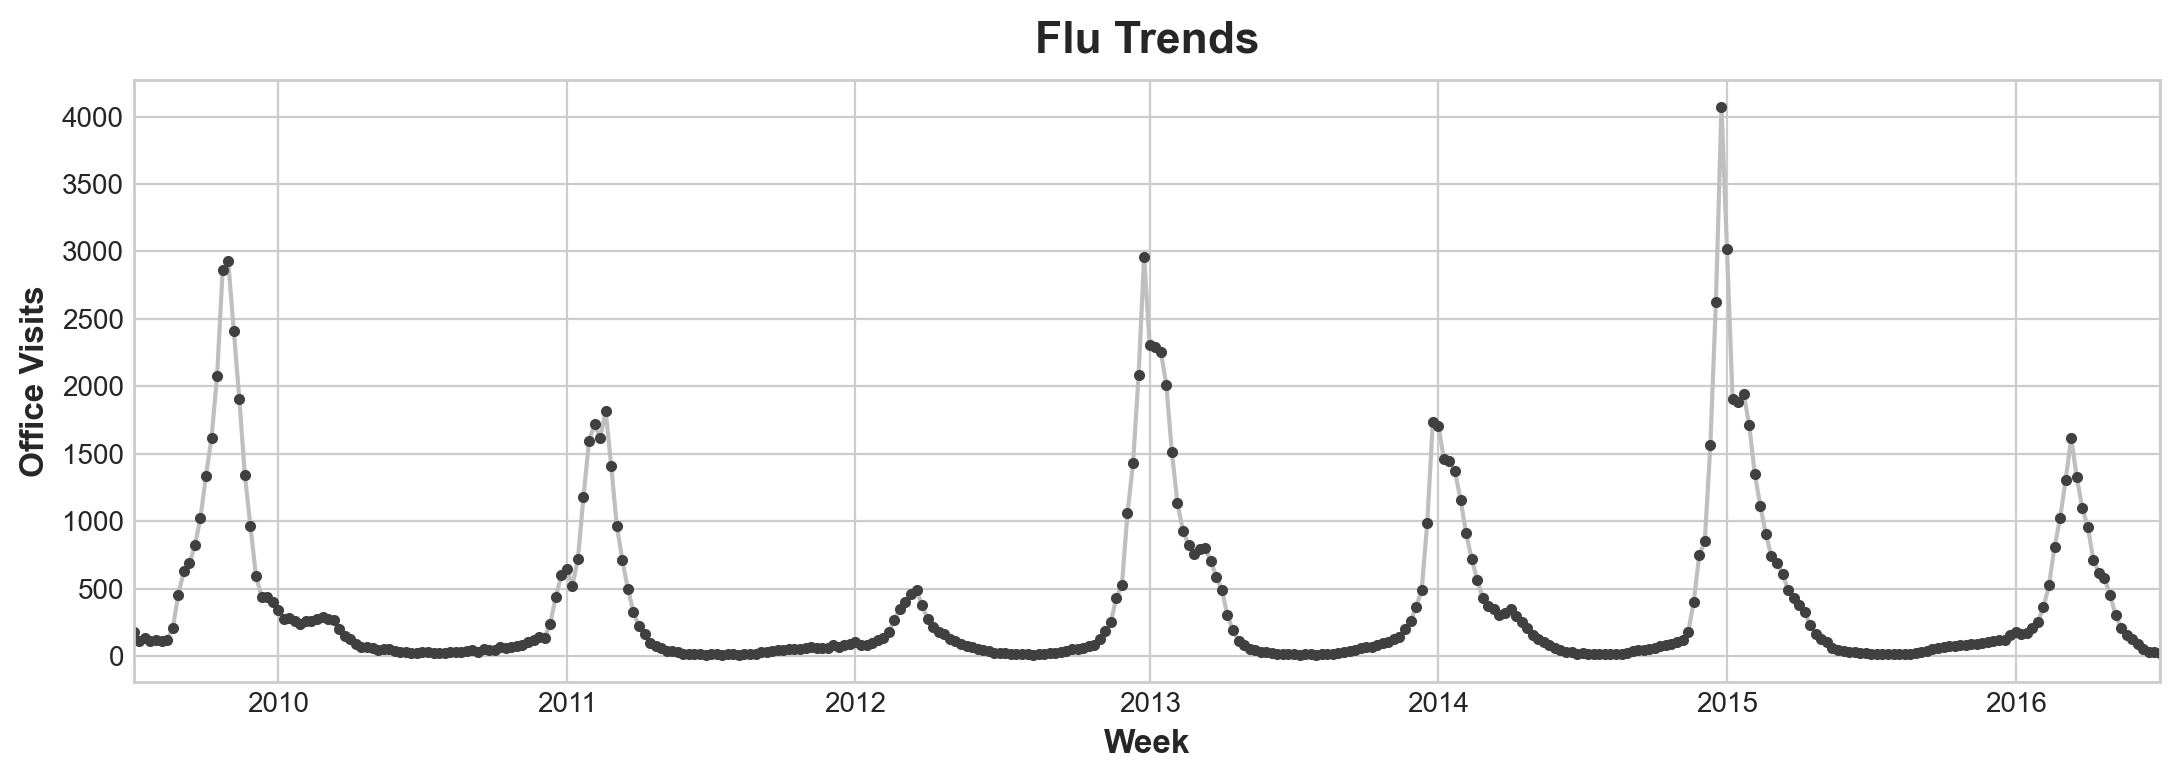

In [20]:
flu_trends = pd.read_csv("./archive/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

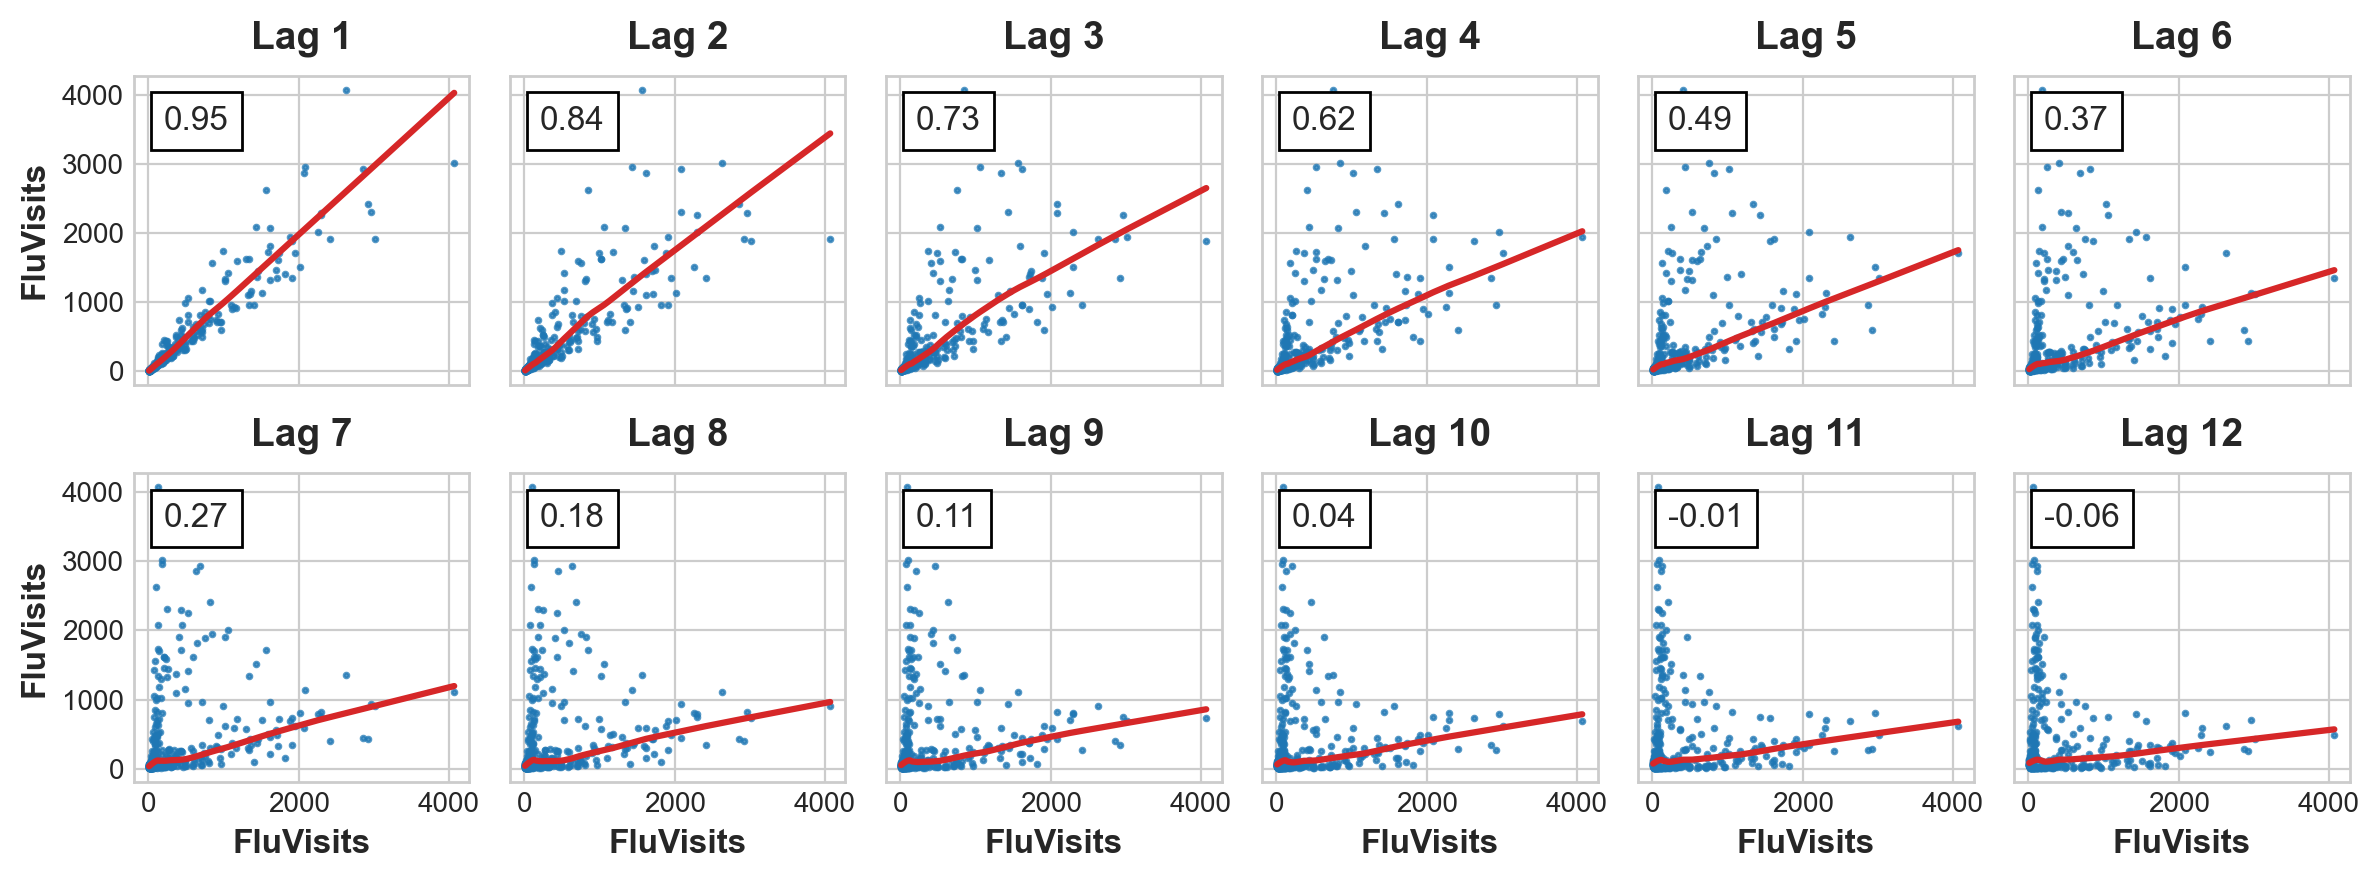

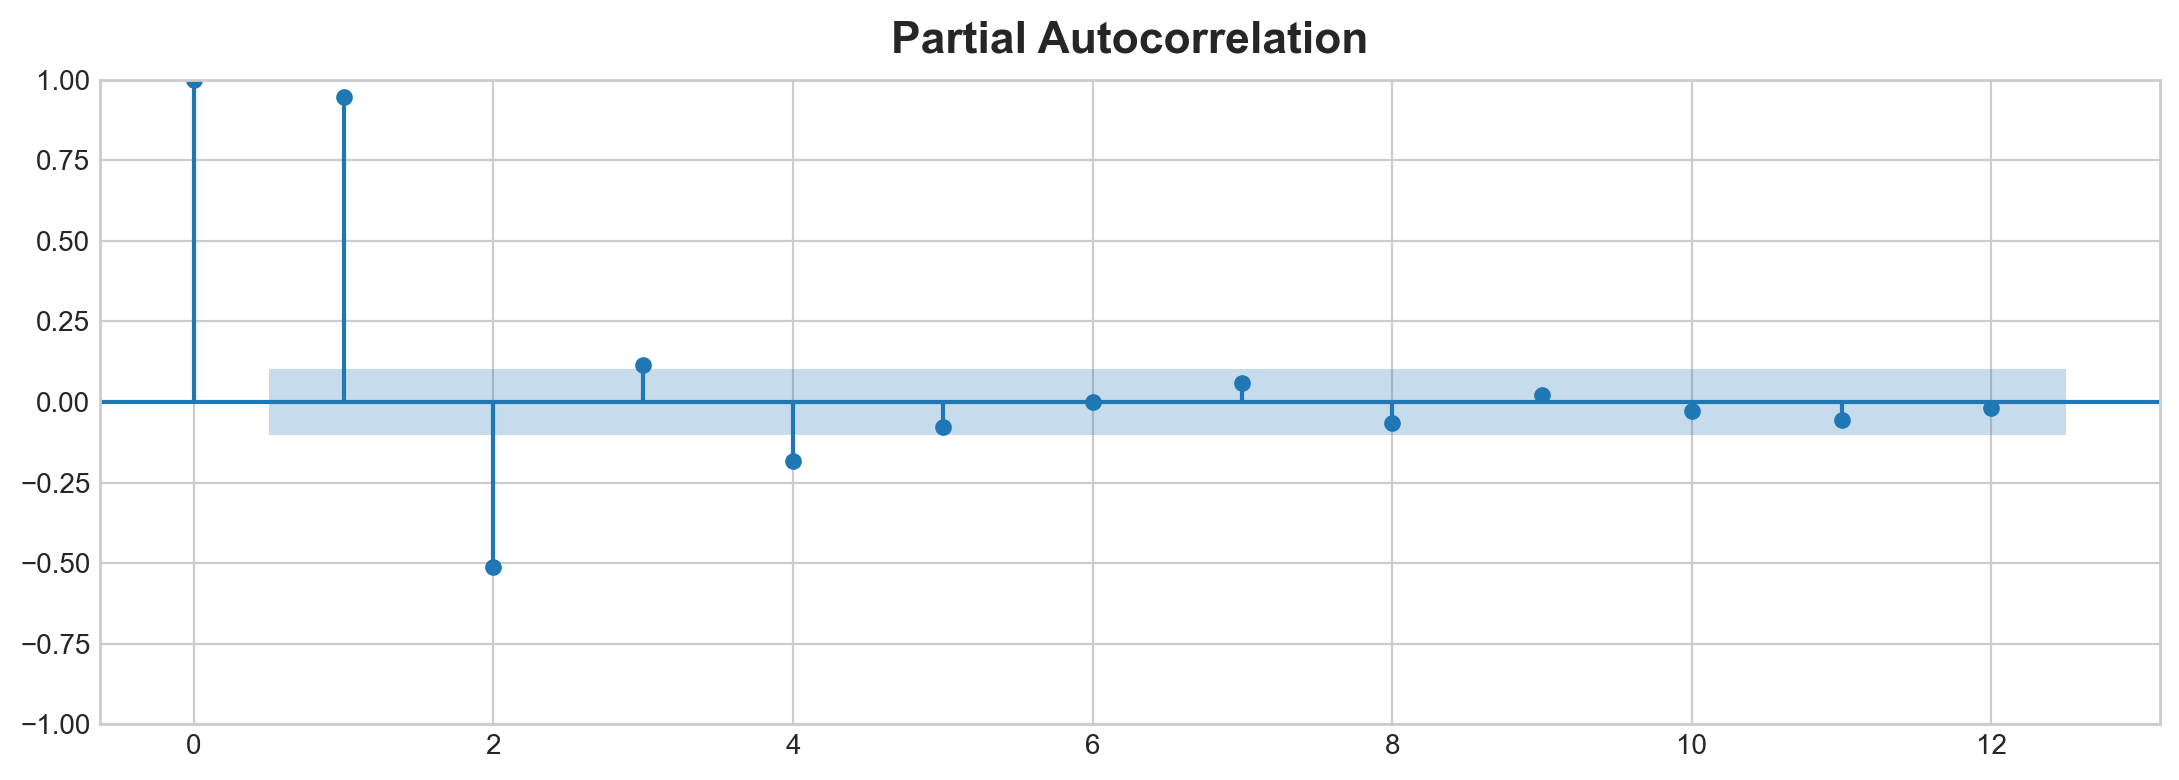

In [21]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

The lag plots indicate that the relationship of FluVisits to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags 1, 2, 3, and 4. We can lag a time series in Pandas with the shift method. For this problem, we'll fill in the missing values the lagging creates with 0.0.

In [22]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In [23]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

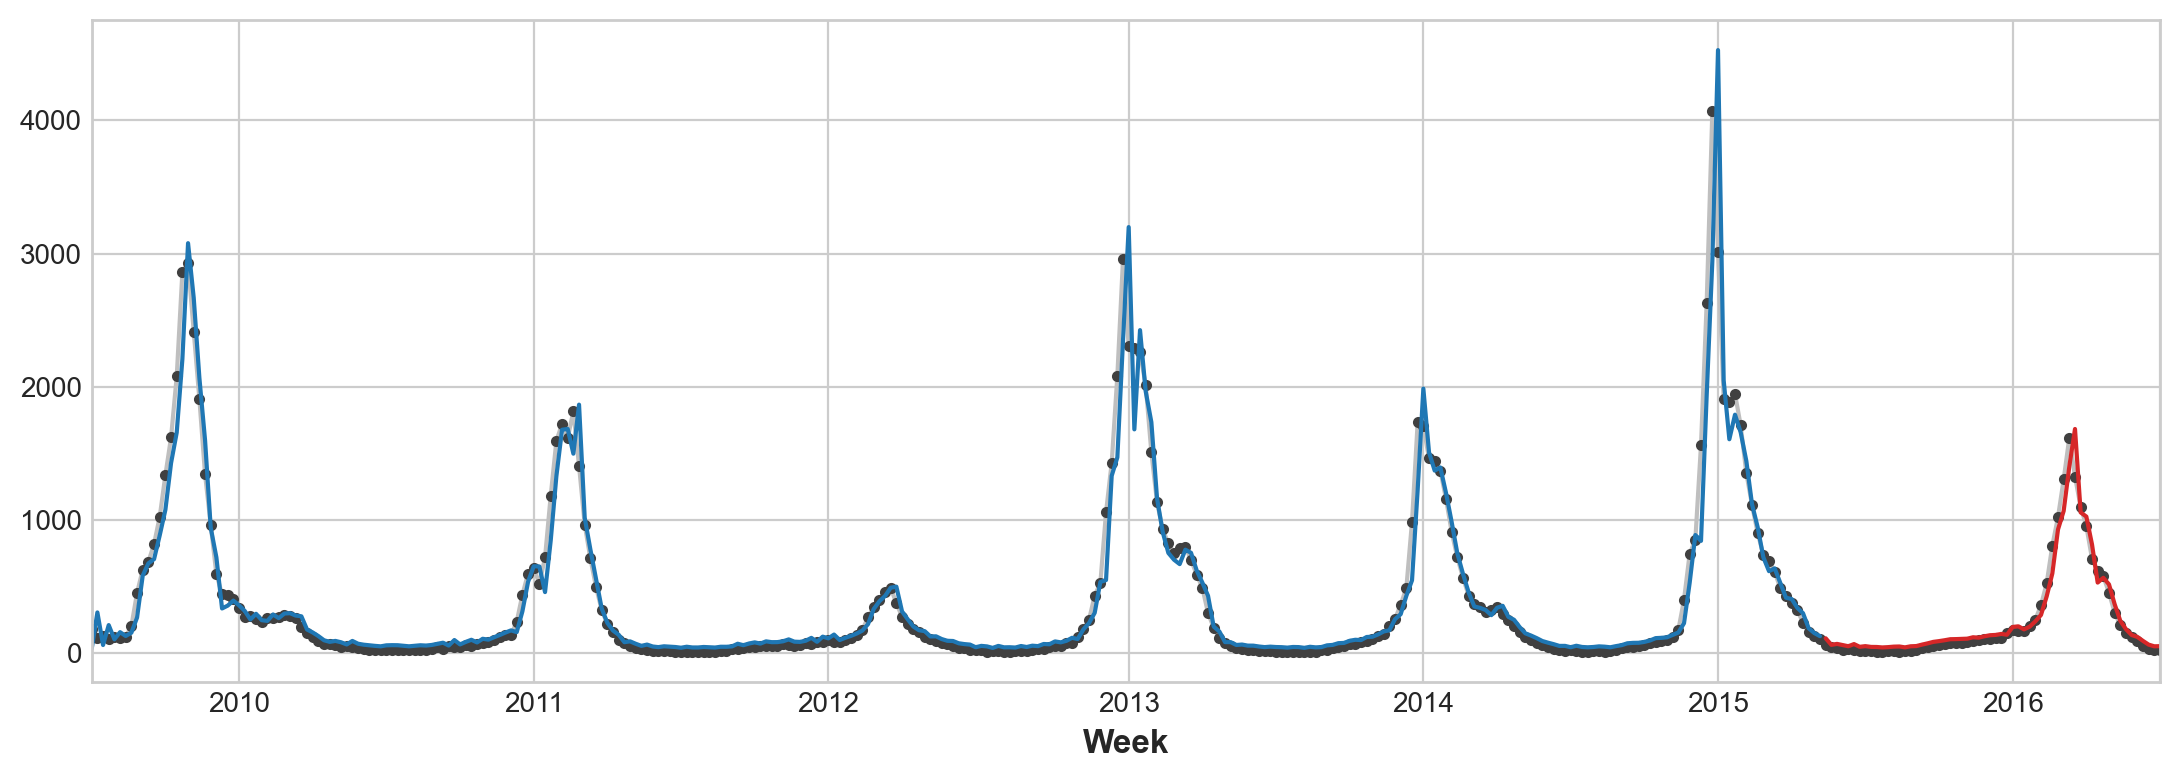

In [24]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

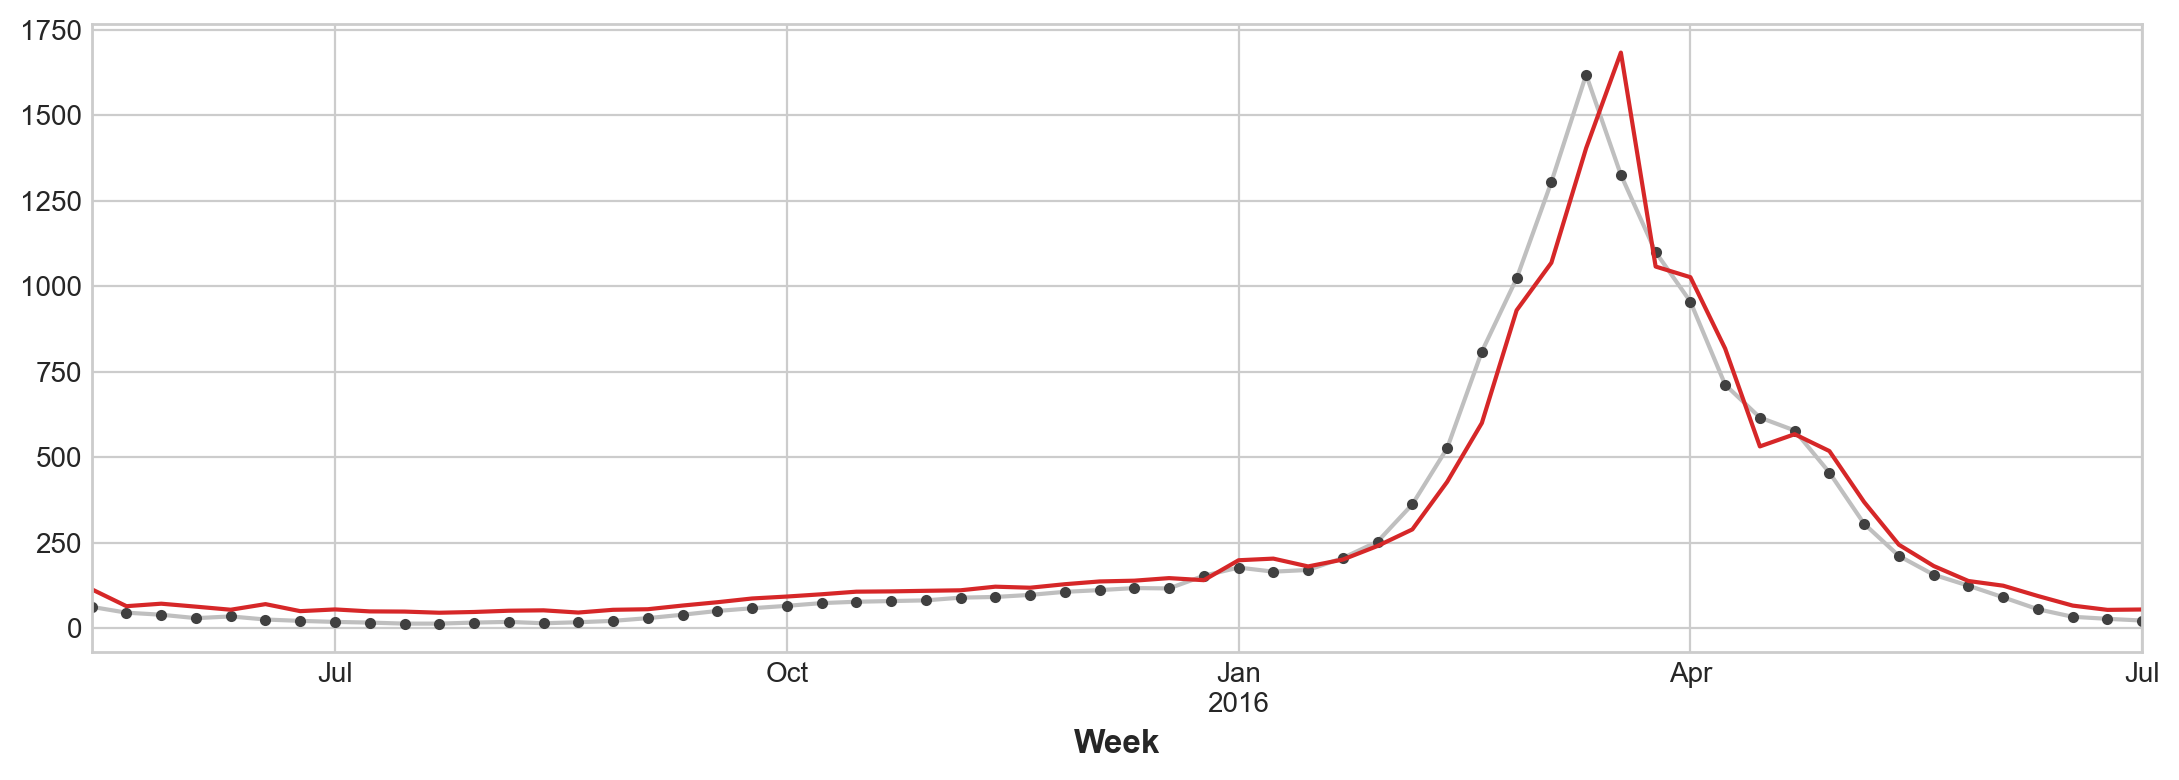

In [25]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')  

To improve the forecast we could try to find leading indicators, time series that could provide an "early warning" for changes in flu cases. For our second approach then we'll add to our training data the popularity of some flu-related search terms as measured by Google Trends.

Plotting the search phrase 'FluCough' against the target 'FluVisits' suggests such search terms could be useful as leading indicators: flu-related searches tend to become more popular in the weeks prior to office visits.

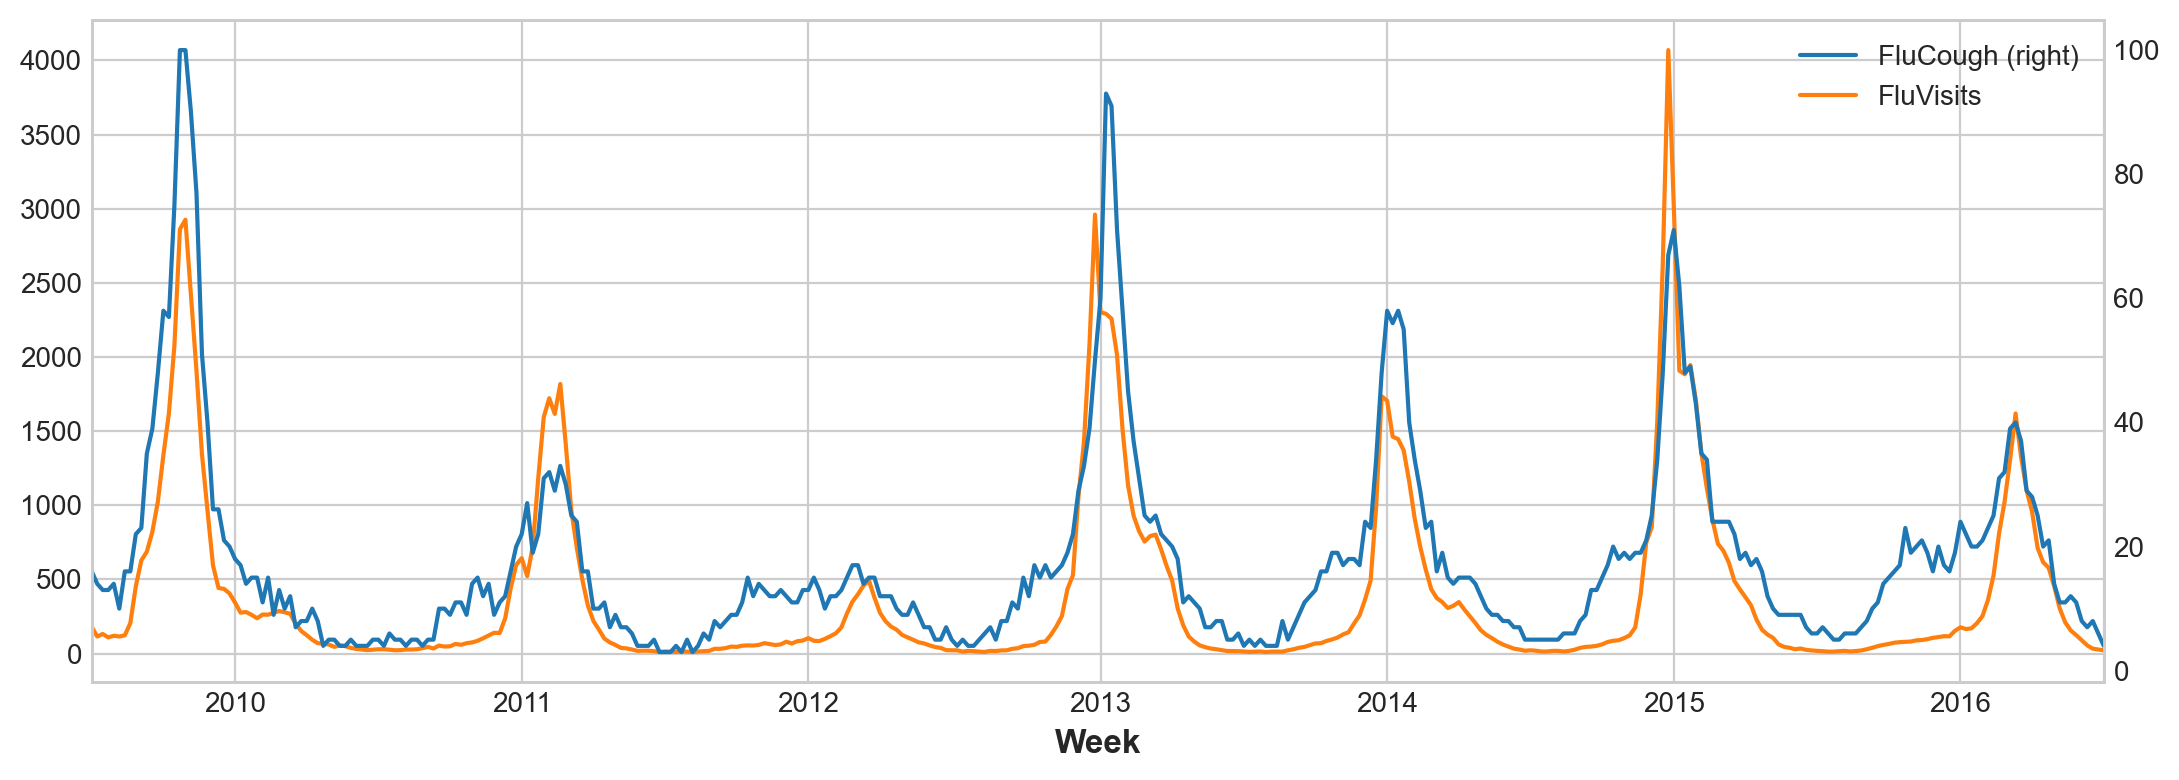

In [26]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

In [27]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

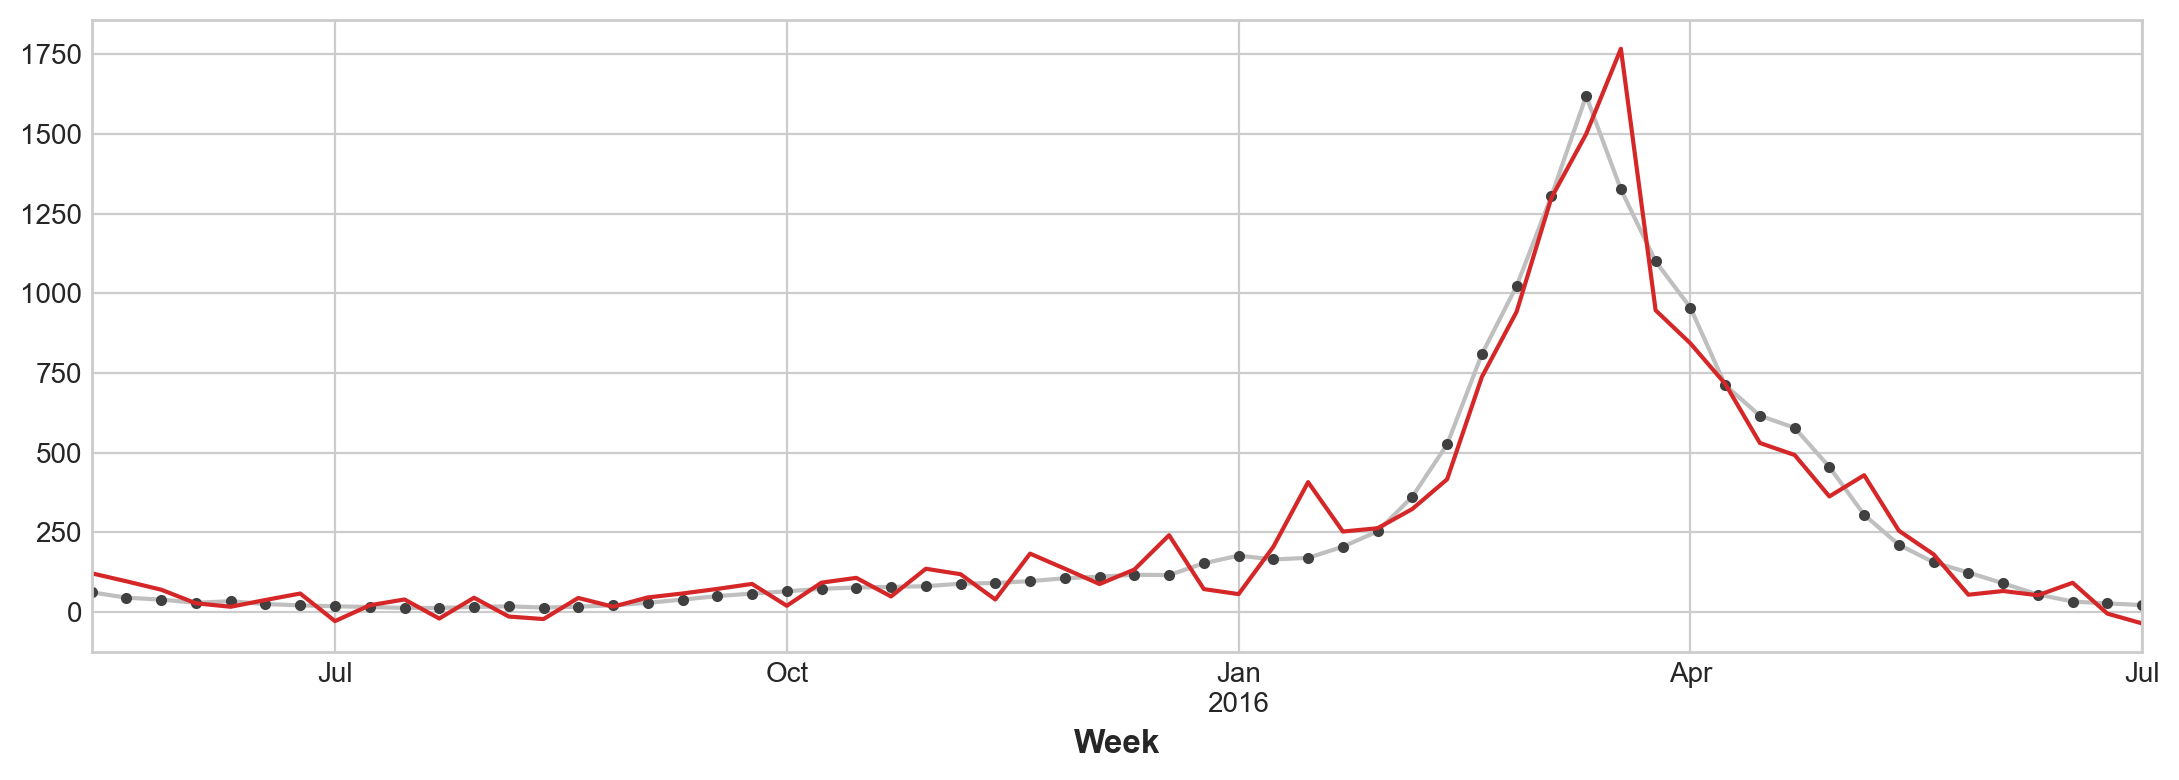

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')